Paper: [Combining LIANA and Tensor-cell2cell to decipher cell-cell communication across multiple samples](https://www.cell.com/cell-reports-methods/fulltext/S2667-2375(24)00089-4)

Tutorial: [Intercellular Context Factorization with Tensor-Cell2cell](https://liana-py.readthedocs.io/en/latest/notebooks/liana_c2c.html)

In [16]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import numpy as np

import liana as li
import cell2cell as c2c
import decoupler as dc


import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict

import os

In [12]:
adata_dir = '/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/LabelTransfer/adatas/full_adata_post_label_transfer.h5ad'
base_dir = '/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/cell2cell' 
os.makedirs(base_dir, exist_ok = True) 
os.chdir(base_dir)

# Load & Prep Data

In [13]:
adata = sc.read_h5ad(adata_dir)

In [14]:
adata

AnnData object with n_obs × n_vars = 152319 × 18088
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'complexity', 'doublet_scores', 'predicted_doublets', 'n_genes', 'n_counts', 'celltypist_labels_Immune_All_High', 'celltypist_scores_Immune_All_High', 'celltypist_labels_Cells_Adult_Breast', 'celltypist_scores_Cells_Adult_Breast', 'batch', 'subtype', 'leiden', 'celltypist_labels_Immune_All_High_highconf', 'GenAnno', 'GenAnnoV1', 'GenAnnoV2', 'celltypist_mapped', 'GenAnnoHighConf', 'cell_type', 'predicted_labels', 'GennAnno_ScAnvi', 'LabelTransferAnno'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'GenAnnoHighConf_colors', 'GenAnnoV1_colors', 'GenAnnoV2_colors', 'GennAnno_ScAnvi_colors', 'LabelTransferAnno_colors', 'celltypist_labels_Immune_All

In [17]:
fraction = 0.1
n_cells = int(fraction * adata.n_obs)
random_indices = np.random.choice(adata.n_obs, size=n_cells, replace=False)
adata_sub = adata[random_indices, :].copy()

In [18]:
adata_sub.obs['context'] = adata_sub.obs.batch.astype(str) + adata_sub.obs.subtype.astype(str)

In [20]:
adata_sub.obs.context.value_counts()

context
B1-MH0177-TNBC     1660
MH0135-TNBC        1502
MH0176-HER2         990
MH0025-ER           821
MH0114-T3-ER        790
PM0337-HER2         745
MH0167-T-ER         651
MH0163-ER           602
B1-Tum0554-TNBC     597
MH0040-ER           568
B1-MH0131-TNBC      566
MH0040-LN-TNBC      565
B1-MH4031-TNBC      512
MH0161-HER2         496
MH0001-ER           462
MH0042-ER           450
MH0031-HER2         432
MH0043-T-ER         413
MH0125-ER           404
AH0308-HER2         385
PM0360-ER           377
AH0319-ER           325
MH0126-TNBC         264
MH0151-ER           254
MH0114-T2-TNBC      173
MH0032-ER           103
SH0106-TNBC          80
MH0069-HER2          44
Name: count, dtype: int64

In [21]:
adata_sub.obs.LabelTransferAnno.value_counts()

LabelTransferAnno
Epithelial           7112
Cycling cells        2538
T cells              1939
Plasma cells          482
B cells               350
unknown               332
mCAF                  314
Endothelial           280
apCAF                 170
iCAF                  168
Mac_AgPres            115
Mac_Angio             113
Mac_LA                112
Mac_IFN               105
RTM_LA                 93
vCAF                   82
RTM_IM                 76
tpCAF                  72
Mac_Hypo               69
Mac_Rec                66
RTM_IFN                65
pDC                    63
breast_normal          61
IDO_CAF                54
Pericyte               51
cDC2_AREG              51
Mono_IL1B              33
Mast_cells             31
MonoInter_CXCL10       31
MonoInter_CLEC10A      29
cDC2_FCER1A            27
cDC4_FCGR3A            24
cDC_CXCL8              23
dCAF                   23
cDC2_CD207             19
cDC1_CLEC9A            19
cDC_LAMP3              17
cDC3_CD14           

In [22]:
adata_sub.obs.subtype.value_counts()

subtype
ER      6220
TNBC    5919
HER2    3092
Name: count, dtype: int64

In [23]:
sample_key = 'context'
condition_key = 'subtype'
groupby = 'LabelTransferAnno'

# Ligand-Receptor Inference by Sample

In [24]:
li.mt.rank_aggregate.by_sample(
    adata_sub,
    groupby=groupby,
    resource_name='consensus', # NOTE: uses human gene symbols!
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False,
    verbose='full', # use 'full' to show all verbose information
    n_perms=None, # exclude permutations for speed
    return_all_lrs=True, # return all LR values
    )

Converting `context` to categorical!
Using resource `consensus`. 0%|                                               | 0/28 [00:00<?, ?it/s]
Using `.X`!
4341 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_Angio, Mac_IFN, Mac_LA, Mast_cells, Pericyte, Plasma cells, RTM_IM, RTM_LA, apCAF, breast_normal, cDC2_CD207, cDC2_FCER1A, cDC4_FCGR3A, cDC_LAMP3, tpCAF
0.54 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 357 samples and 701 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|█▍                                       | 1/28 [00:05<02:39,  5.92s/it]
Using `.X`!
4731 features of mat are empty, they will be removed.
The following cell identities were excluded: IDO_CAF, Mac_Hypo, Mac_Rec, Mast_cells, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, Plasma cells, RTM_IFN, RTM_IM, cDC2_AREG, cDC3_CD14, dCAF, pDC, unknown, vCAF
0.46 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 295 samples and 892 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.:   7%|██▌                                 | 2/28 [00:17<03:57,  9.13s/it]
Using `.X`!
5340 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, RTM_LA, T cells, apCAF, cDC2_AREG
0.66 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 554 samples and 452 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.:  11%|███▊                                | 3/28 [00:20<02:36,  6.27s/it]
Using `.X`!
6366 features of mat are empty, they will be removed.
The following cell identities were excluded: Mast_cells, breast_normal, cDC1_CLEC9A, cDC2_FCER1A, cDC_CXCL8, dCAF, hsp_tpCAF, vCAF
0.54 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 1640 samples and 735 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.:  14%|█████▏                              | 4/28 [01:06<08:51, 22.16s/it]
Using `.X`!
5058 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, IDO_CAF, Mac_Angio, Mac_IFN, Plasma cells, T cells, apCAF, iCAF, tpCAF, unknown
0.61 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 496 samples and 534 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC


Using resource `consensus`.C:  18%|██████▎                            | 5/28 [01:09<05:49, 15.18s/it]


Running NATMI
Running SingleCellSignalR


Using `.X`!
4379 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_Angio, Mac_IFN, Mac_LA, Mast_cells, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, RTM_LA, breast_normal, cDC1_CLEC9A, cDC2_CD207, cDC2_FCER1A, cDC3_CD14, cDC4_FCGR3A, cDC_CXCL8, dCAF, mCAF
0.45 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 554 samples and 898 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|████████▊                                | 6/28 [01:36<07:02, 19.20s/it]
Using `.X`!
9304 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, Mac_AgPres, Mac_LA, Pericyte, breast_normal, dCAF, tpCAF
0.73 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 446 samples and 335 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|██████████▎                              | 7/28 [01:38<04:48, 13.72s/it]
Using `.X`!
5914 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Mac_Angio, Mac_Hypo, Mac_LA, Mast_cells, RTM_IM, RTM_LA, breast_normal, cDC2_FCER1A, cDC_CXCL8, dCAF, iCAF
0.57 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 793 samples and 632 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.29%|███████████▏                           | 8/28 [01:47<04:02, 12.12s/it]
Using `.X`!
6408 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Mac_Hypo, Mac_IFN, Mac_Rec, MonoInter_CLEC10A, Mono_IL1B, T cells, breast_normal, cDC2_AREG, cDC2_FCER1A, cDC_CXCL8, dCAF, pDC, vCAF
0.55 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 400 samples and 698 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|█████████████▏                           | 9/28 [02:01<04:02, 12.74s/it]
Using `.X`!
5397 features of mat are empty, they will be removed.
The following cell identities were excluded: IDO_CAF, Mac_AgPres, MonoInter_CLEC10A, Mono_IL1B, Plasma cells, RTM_IM, apCAF, cDC2_AREG, cDC3_CD14, cDC_CXCL8, mCAF, unknown, vCAF
0.50 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 84 samples and 805 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|██████████████▎                         | 10/28 [02:05<02:57,  9.86s/it]
Using `.X`!
6938 features of mat are empty, they will be removed.
The following cell identities were excluded: Endothelial, Mac_AgPres, RTM_LA, apCAF, cDC2_AREG, cDC2_FCER1A, mCAF, unknown
0.69 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 557 samples and 397 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC


Now running: MH0040-LN-TNBC:  39%|█████████████▊                     | 11/28 [02:08<02:12,  7.82s/it]

Running NATMI
Running SingleCellSignalR


Using resource `consensus`.
Using `.X`!
6074 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, IDO_CAF, Mac_Angio, Mac_IFN, Mac_LA, Mast_cells, MonoInter_CLEC10A, Mono_IL1B, Plasma cells, RTM_LA, apCAF, breast_normal, cDC2_AREG, cDC2_FCER1A, cDC3_CD14, tpCAF, unknown, vCAF
0.64 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 535 samples and 501 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|█████████████████▏                      | 12/28 [02:11<01:44,  6.55s/it]
Using `.X`!
7077 features of mat are empty, they will be removed.
The following cell identities were excluded: Endothelial, Mac_Angio, Mac_IFN, Mast_cells, MonoInter_CLEC10A, Plasma cells, RTM_IM, apCAF, cDC_CXCL8
0.66 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 434 samples and 474 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.46%|█████████████████▋                    | 13/28 [02:16<01:28,  5.93s/it]
Using `.X`!
6254 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, Plasma cells, RTM_IM, RTM_LA, T cells, apCAF, breast_normal, cDC1_CLEC9A, cDC2_CD207, cDC2_FCER1A, cDC3_CD14, cDC4_FCGR3A, cDC_CXCL8, tpCAF, vCAF
0.58 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 377 samples and 624 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.50%|███████████████████                   | 14/28 [02:22<01:24,  6.03s/it]
Using `.X`!
7121 features of mat are empty, they will be removed.
The following cell identities were excluded: Endothelial, Mac_Angio, MonoInter_CLEC10A, Mono_IL1B, Plasma cells, RTM_IM, breast_normal, cDC1_CLEC9A, iCAF, mCAF, unknown, vCAF
0.60 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 28 samples and 616 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.:  54%|██████████████████▊                | 15/28 [02:25<01:05,  5.00s/it]
Using `.X`!
5164 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, IDO_CAF, Mac_AgPres, Mac_LA, Mast_cells, MonoInter_CXCL10, Mono_IL1B, Pericyte, RTM_IFN, cDC1_CLEC9A, cDC2_AREG, cDC3_CD14, cDC_LAMP3, unknown, vCAF
0.48 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 145 samples and 850 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`. 57%|█████████████████████▏               | 16/28 [02:28<00:54,  4.57s/it]
Using `.X`!
5422 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, IDO_CAF, Mac_AgPres, Mac_LA, MonoInter_CLEC10A, Pericyte, RTM_IM, RTM_LA, breast_normal, cDC2_AREG, cDC2_FCER1A, cDC_CXCL8, tpCAF
0.54 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 762 samples and 696 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|████████████████████████▎               | 17/28 [02:36<00:59,  5.40s/it]
Using `.X`!
7100 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, Mac_AgPres, Mast_cells, Pericyte, Plasma cells, cDC1_CLEC9A, cDC2_AREG, iCAF, tpCAF, vCAF
0.64 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 383 samples and 492 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.64%|████████████████████████▍             | 18/28 [02:39<00:48,  4.81s/it]
Using `.X`!
4361 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, IDO_CAF, Mac_Angio, Mac_Rec, MonoInter_CXCL10, Mono_IL1B, RTM_IM, RTM_LA, apCAF, cDC1_CLEC9A, cDC2_AREG, cDC4_FCGR3A, cDC_LAMP3, dCAF, pDC, tpCAF
0.47 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 230 samples and 852 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.68%|█████████████████████████▊            | 19/28 [02:47<00:50,  5.61s/it]
Using `.X`!
5990 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Mac_AgPres, Mac_IFN, Mac_Rec, MonoInter_CLEC10A, MonoInter_CXCL10, cDC1_CLEC9A, cDC2_AREG, cDC_CXCL8, mCAF, tpCAF
0.60 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 1476 samples and 554 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|████████████████████████████▌           | 20/28 [02:55<00:51,  6.46s/it]
Using `.X`!
4141 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_AgPres, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, Plasma cells, RTM_IM, apCAF, cDC2_AREG, cDC2_FCER1A, cDC_LAMP3, hsp_tpCAF, pDC, tpCAF, vCAF
0.45 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 228 samples and 908 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.75%|████████████████████████████▌         | 21/28 [03:03<00:47,  6.84s/it]
Using `.X`!
5351 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Mac_Angio, Mac_IFN, Mac_LA, MonoInter_CXCL10, Mono_IL1B, Pericyte, Plasma cells, RTM_LA, breast_normal, cDC2_FCER1A, cDC_CXCL8, mCAF, tpCAF, unknown, vCAF
0.60 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 470 samples and 587 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|███████████████████████████████▍        | 22/28 [03:07<00:35,  5.89s/it]
Using `.X`!
6360 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, IDO_CAF, Mac_AgPres, Mac_Angio, Mac_IFN, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, Plasma cells, apCAF, cDC2_FCER1A, cDC4_FCGR3A, mCAF, vCAF
0.67 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 578 samples and 453 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.82%|███████████████████████████████▏      | 23/28 [03:11<00:27,  5.42s/it]
Using `.X`!
5328 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, Mac_AgPres, Mac_Angio, Mac_IFN, Mac_LA, MonoInter_CLEC10A, RTM_IFN, breast_normal, cDC_CXCL8, tpCAF, vCAF
0.59 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 633 samples and 601 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.86%|████████████████████████████████▌     | 24/28 [03:15<00:20,  5.00s/it]
Using `.X`!
5096 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_Angio, Mac_Hypo, Mac_IFN, Mac_LA, MonoInter_CLEC10A, Mono_IL1B, Pericyte, RTM_IFN, RTM_IM, RTM_LA, cDC2_CD207, cDC2_FCER1A, cDC3_CD14, cDC4_FCGR3A, cDC_CXCL8, cDC_LAMP3, tpCAF, vCAF
0.51 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 947 samples and 799 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.89%|█████████████████████████████████▉    | 25/28 [03:34<00:27,  9.14s/it]
Using `.X`!
5584 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_Angio, Mac_Hypo, Mac_LA, Mast_cells, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, breast_normal, cDC2_AREG, cDC3_CD14, tpCAF, vCAF
0.56 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 718 samples and 682 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|█████████████████████████████████████▏  | 26/28 [03:45<00:19,  9.90s/it]
Using `.X`!
5374 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_AgPres, MonoInter_CLEC10A, Mono_IL1B, RTM_LA, apCAF, cDC1_CLEC9A, cDC2_FCER1A, cDC3_CD14, iCAF, mCAF, pDC, unknown
0.55 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 358 samples and 690 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.96%|████████████████████████████████████▋ | 27/28 [03:50<00:08,  8.35s/it]
Using `.X`!
5731 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Cycling cells, Endothelial, IDO_CAF, Mac_Hypo, Mac_IFN, Mac_Rec, Mast_cells, MonoInter_CXCL10, RTM_IM, RTM_LA, cDC2_AREG, cDC2_CD207, cDC4_FCGR3A, iCAF, pDC
0.50 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 50 samples and 823 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Now running: SH0106-TNBC: 100%|██████████████████████████████████████| 28/28 [03:53<00:00,  8.36s/it]


Check results



In [25]:
adata_sub.uns["liana_res"].sort_values("magnitude_rank").head(10)

,context,source,target,ligand_complex,receptor_complex,lr_means,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank
1513989,B1-Tum0554-TNBC,Mac_Hypo,RTM_IM,MIF,CD74_CXCR4,4.129988,16.023512,1.476322,2.131896,0.010244,0.961318,5.613071e-11
3690674,MH0176-HER2,mCAF,Mast_cells,LGALS1,CD69,3.625341,13.136650,2.697440,3.397565,0.040223,0.955348,1.295138e-10
340361,B1-MH0177-TNBC,mCAF,Mono_IL1B,COL1A1,CD44,3.875005,13.479287,3.326442,3.597834,0.013680,0.955912,1.716552e-10
2392322,MH0031-HER2,Pericyte,IDO_CAF,TIMP1,CD63,4.312468,18.325613,1.973883,2.842459,0.019016,0.960313,2.624254e-10
4175054,PM0337-HER2,Epithelial,RTM_LA,MIF,CD74_CXCR4,4.084883,15.736550,1.393957,2.011603,0.012843,0.959289,4.107793e-10
79424,AH0319-ER,tpCAF,RTM_LA,MIF,CD74_CXCR4,4.179569,16.610783,1.786582,2.519485,0.030534,0.962861,4.198203e-10
340362,B1-MH0177-TNBC,Mac_Hypo,Mono_IL1B,SPP1,CD44,3.822410,13.202061,2.317263,3.158928,0.010322,0.955472,4.768190e-10
1513990,B1-Tum0554-TNBC,Mac_Hypo,Mac_AgPres,MIF,CD74_CXCR4,4.051466,15.534555,1.425248,1.967207,0.009931,0.960738,5.051747e-10
1513991,B1-Tum0554-TNBC,tpCAF,tpCAF,TIMP1,CD63,3.971843,15.199804,2.649735,3.361107,0.017063,0.960325,8.980868e-10
340364,B1-MH0177-TNBC,mCAF,Mono_IL1B,COL1A2,CD44,3.777770,12.966761,3.200382,3.491896,0.012459,0.955088,9.345634e-10


# Building a Tensor

In [26]:
tensor = li.multi.to_tensor_c2c(adata_sub,
                                sample_key=sample_key,
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

100%|████████████████████████████████████████████████████████████████| 28/28 [00:45<00:00,  1.63s/it]


In [28]:
tensor.tensor.shape

(28, 149, 37, 37)

Build Metadata

In [29]:
context_dict = adata_sub.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict) # add unkown to missing keys

In [35]:
tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

# Running Tensor-cell2cell

In [38]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=6, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

Running Tensor Factorization


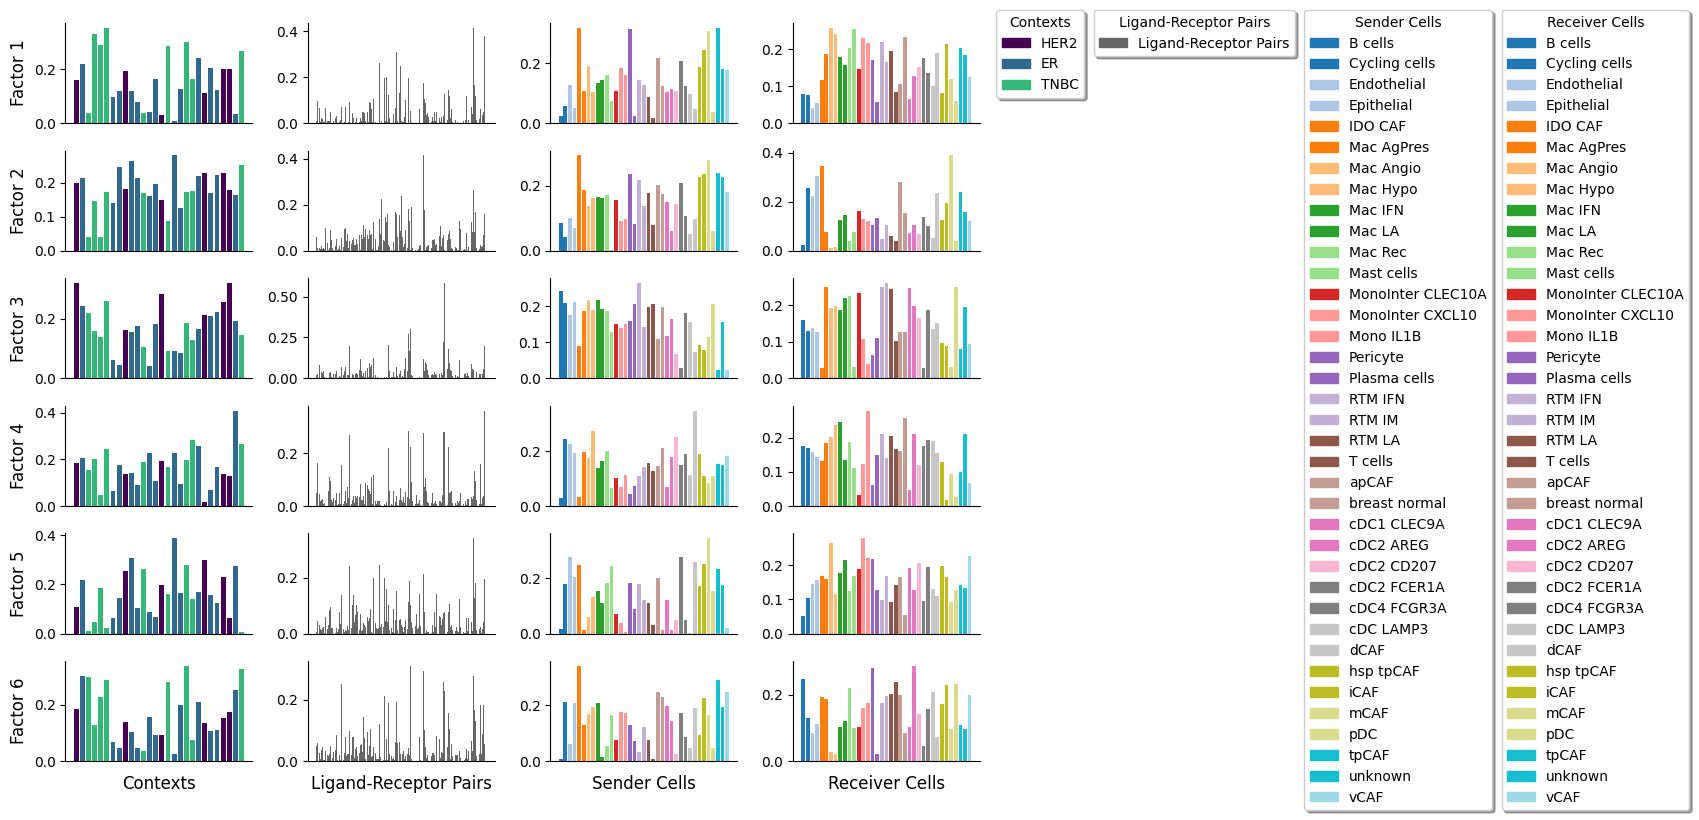

In [39]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )

# Factorization Results

Each factor gets 4 vectors, one per dimension of the 4D tensor
In factors the loadings (weights assigned) of the decomposition are stored, e.g, for each dimension (contexts, LR pair, Sender Cells, Receiver cells), how much does each individual contribute to the factor itself

In [40]:
factors = tensor.factors

In [44]:
factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

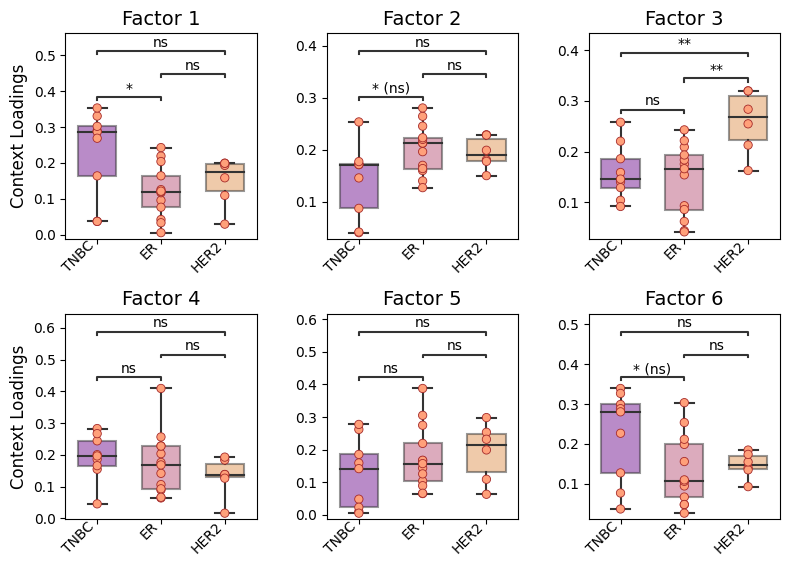

In [45]:
_ = c2c.plotting.context_boxplot(context_loadings=factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=2,
                                 figsize=(8, 6),
                                 statistical_test='t-test_ind',
                                 pval_correction='fdr_bh',
                                 cmap='plasma',
                                 verbose=False,
                                )


(<Figure size 800x800 with 1 Axes>, <Axes: title={'center': 'Factor 3'}>)

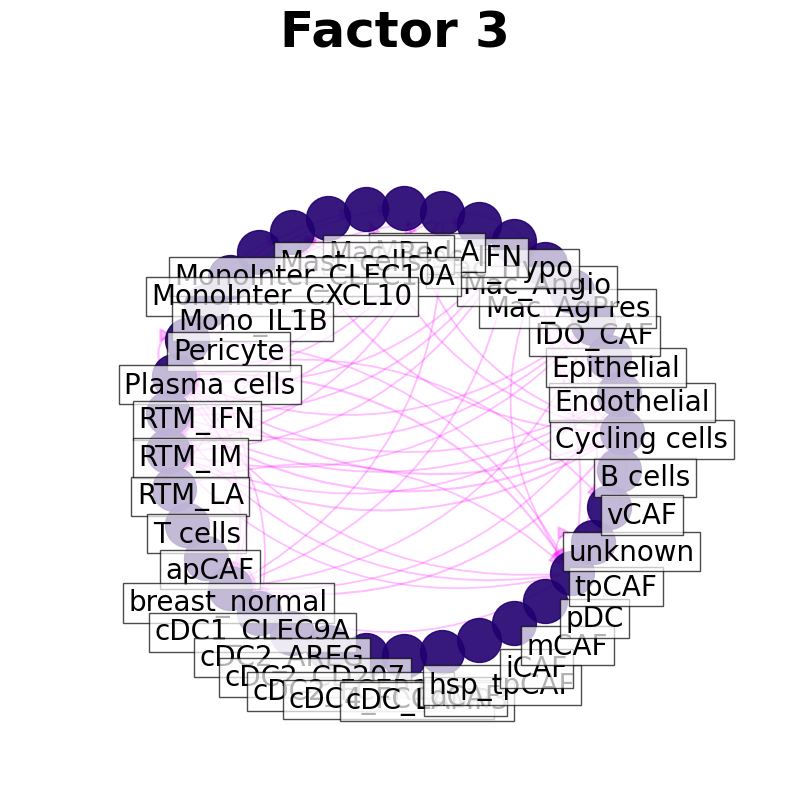

In [47]:
c2c.plotting.ccc_networks_plot(factors,
                               included_factors=['Factor 3'],
                               network_layout='circular',
                               ccc_threshold=0.05, # Only important communication
                               nrows=1,
                               panel_size=(8, 8), # This changes the size of each figure panel.
                              )


In [48]:
lr_loadings = factors['Ligand-Receptor Pairs']

In [49]:
lr_loadings

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
ACTR2^LDLR,0.008512,0.057816,0.021778,0.047856,0.003814,0.048086
ADAM10^CD44,0.094270,0.010439,0.025378,0.162203,0.045779,0.059366
ADAM10^GPNMB,0.064166,0.012181,0.084608,0.045533,0.032433,0.026721
ADAM10^NOTCH1,0.004378,0.008224,0.004273,0.018352,0.015541,0.007866
ADAM10^NOTCH2,0.021953,0.021338,0.038179,0.022398,0.012860,0.034792
...,...,...,...,...,...,...
VEGFA^GPC1,0.000409,0.017220,0.000958,0.007376,0.002903,0.022295
VEGFA^ITGAV,0.034800,0.022368,0.024958,0.031064,0.015499,0.089062
VEGFA^ITGB1,0.050342,0.068861,0.058861,0.037636,0.041443,0.183141
VIM^CD44,0.379332,0.157591,0.200918,0.362731,0.195109,0.056606


# Downstream Analysis

In [51]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)

0.00B [00:00, ?B/s]

In [54]:
net.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [52]:
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [53]:
lr_pairs.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


In [55]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

,source,interaction,weight
60,JAK-STAT,LGALS9^PTPRC,1.307807
844,JAK-STAT,LGALS9^CD47,2.054778
1130,Trail,LGALS9^PTPRK,0.937003
1432,JAK-STAT,LGALS9^HAVCR2,1.487678
1779,EGFR,DLL1^NOTCH1,-1.000584


In [56]:
# run enrichment analysis
estimate, pvals = dc.run_ulm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

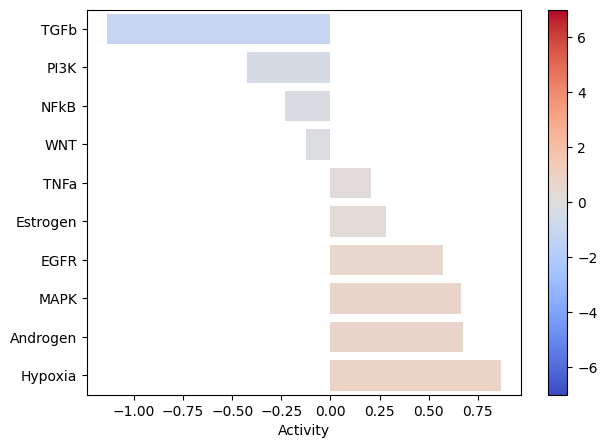

In [57]:
dc.plot_barplot(estimate, 'Factor 3', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)